In [1]:
import itertools
import math
import time 
import numpy as np
import torch
import torchvision
from torch.utils.data import Dataset
from torch.nn.utils import spectral_norm
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch import autograd
import matplotlib.pyplot as plt
from IPython import display
from torch.autograd import Variable
import gc
import glob
from tqdm.auto import tqdm
import os
import torch.nn.functional as F
import random as rand
from PIL import Image
import cv2 as cv
from datetime import datetime
#from torchsummary import summary

In [2]:
path = os.getcwd()
path

'C:\\Users\\great\\projects\\pet'

In [3]:
files = glob.glob(path + '\\NIR-DOG\\*\\*.jpg')
#files = glob.glob(path + '\\mew\\images\\*.jpg')

In [4]:
len(files)

5239

In [5]:
img = cv.imread(files[100])
img.shape

(512, 512, 3)

In [6]:
img.shape

(512, 512, 3)

In [7]:
IMG_SIZE = 128

transforms1 = transforms.Compose(
    [
        
        #transforms.CenterCrop(380),
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        #transforms.Grayscale(num_output_channels=1)
    ]
)


class FaceDataset(Dataset):

    def __init__(self, df, transforms=None):
        super().__init__()
        self.df_data = df
        self.transforms = transforms

    def __len__(self):
        return len(self.df_data)

    def __getitem__(self, index):
        img_path = self.df_data[index]
        img =   Image.open(img_path).convert("RGB")
        #print(img_path)
        if(img_path[-8] == '_'):
            pnt_path = img_path + '.cat'
            pnts = np.loadtxt(pnt_path, dtype=int)
            #print(pnts, pnts[::2], pnts[1::2])
            ymin = np.min(pnts[2::2])
            ymax = np.max(pnts[2::2])
            xmin = np.min(pnts[1::2])
            xmax = np.max(pnts[1::2])
            
            w, h = img.size

            ymin = max(0, ymin - 10)
            xmin = max(0, xmin - 10)
            ymax = min(h, ymax + 10)
            xmax = min(w, xmax + 10)
            m = max(xmax-xmin, ymax-ymin)
            ymax = ymin + m
            xmax = xmin + m
            img = img.crop((xmin, ymin, xmax, ymax))
        #img = np.array(img, dtype=float)
        if self.transforms is not None:
            img = self.transforms(img)
        #img = img.resize((60,60))
        return np.array(img)

In [8]:
ds = FaceDataset(files, transforms1)
batch_size = 8
print(ds[10].min(), ds[10].max())

-1.0 0.9137255


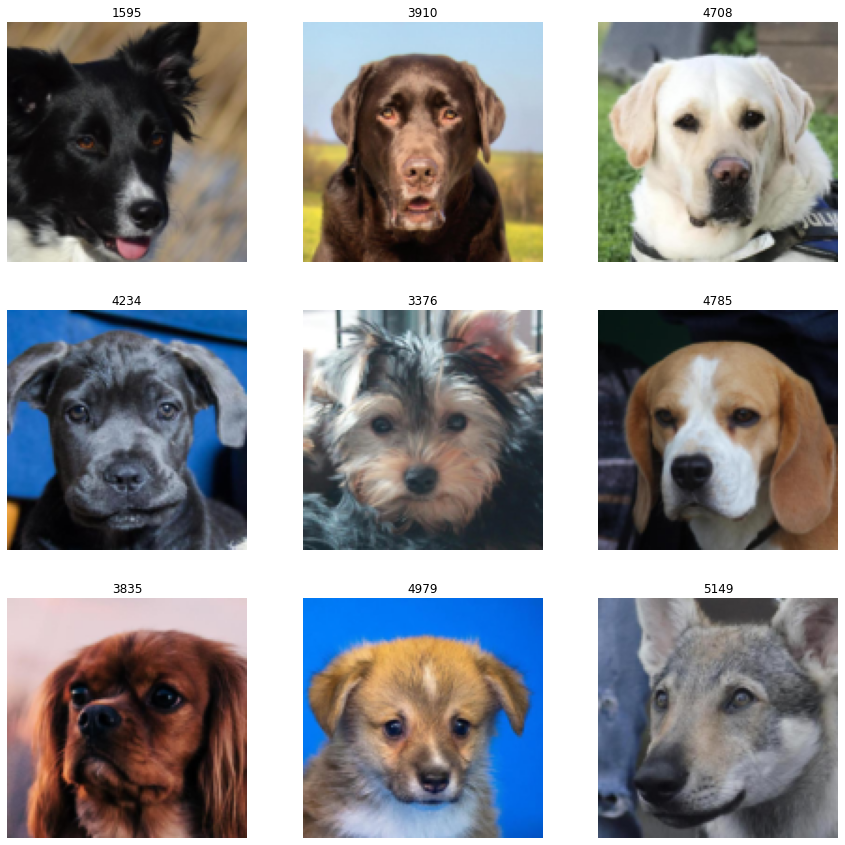

In [9]:
plt.figure(figsize=(15,15))
for i in range(9):
    ind = rand.randint(0,len(ds))
    
    plt.subplot(3, 3, 1 + i)
    img = np.array((ds[ind]+1.)/2, dtype=float)
    img = np.swapaxes(img,0,2)
    img = np.swapaxes(img,0,1)
    plt.title(str(ind))
    plt.axis('off')  
    plt.imshow(img)
plt.show()


In [10]:
dl = torch.utils.data.DataLoader(dataset=ds,
                                     batch_size=batch_size,
                                     #pin_memory=True,
                                     shuffle=True)

In [11]:
class Generator(torch.nn.Module):
    def __init__(self, channels):
        super().__init__()
        # Filters [1024, *512, 256]
        # Input_dim = 100
        # Output_dim = C (number of channels)
        self.layer1 = nn.Sequential(
            # Z latent vector 100
            nn.ConvTranspose2d(in_channels=100, out_channels=2048, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(num_features=2048),
            nn.ReLU(True))
        self.layer2 = nn.Sequential(
            # State (1024x4x4)
            nn.ConvTranspose2d(in_channels=2048, out_channels=1024, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(True))
        self.layer3 = nn.Sequential(
            # State (512x8x8)
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(True))
        self.layer4= nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(True))
        self.layer5= nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(True))
        self.final = nn.Sequential(
            # State (256x16x16)
            nn.ConvTranspose2d(in_channels=128, out_channels=channels, kernel_size=4, stride=2, padding=1))
            # output of main module --> Image (Cx32x32)

        self.output = nn.Tanh()

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.final(x)
        return self.output(x)

In [12]:
class Discriminator(torch.nn.Module):
    def __init__(self, channels):
        super().__init__()
        # Filters [256, 512, 1024]
        # Input_dim = channels (Cx64x64)
        # Output_dim = 1
        self.layer1 = nn.Sequential(
            # Omitting batch normalization in critic because our new penalized training objective (WGAN with gradient penalty) is no longer valid
            # in this setting, since we penalize the norm of the critic's gradient with respect to each input independently and not the enitre batch.
            # There is not good & fast implementation of layer normalization --> using per instance normalization nn.InstanceNorm2d()
            # Image (Cx32x32)
            nn.Conv2d(in_channels=channels, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(64, affine=True),
            nn.LeakyReLU(0.2, inplace=True))
        self.layer2 = nn.Sequential(
            # State (256x16x16)
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128, affine=True),
            nn.LeakyReLU(0.2, inplace=True))
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256, affine=True),
            nn.LeakyReLU(0.2, inplace=True))
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(0.2, inplace=True))
        self.layer5 = nn.Sequential(
            # State (512x8x8)
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(1024, affine=True),
            nn.LeakyReLU(0.2, inplace=True))
            # output of main module --> State (1024x4x4)

        self.output = nn.Sequential(
            # The output of D is no longer a probability, we do not apply sigmoid at the output of D.
            nn.Conv2d(in_channels=1024, out_channels=1, kernel_size=4, stride=1, padding=0))


    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        return self.output(x)

    def feature_extraction(self, x):
        # Use discriminator for feature extraction then flatten to vector of 16384
        x = self.main_module(x)
        return x.view(-1, 1024*4*4)

In [13]:
# layer1 = nn.Sequential(
#             nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
#             #nn.BatchNorm2d(16, track_running_stats=False),
#             nn.ReLU(),
#             #nn.Dropout(0.5),
#             nn.MaxPool2d(kernel_size=2, stride=2))
# img = Variable(torch.randn(128, 3, IMG_SIZE, IMG_SIZE)))
# img.shape

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
discriminator = Discriminator(3)#torchvision.models.resnet18()
#fix_arch(discriminator, 2)
#discriminator = discriminator.to(device)
discriminator = discriminator.cuda()
#discriminator.apply(clipper)
discriminator

Discriminator(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, 

In [16]:
generator = Generator(3).cuda()
generator

Generator(
  (layer1): Sequential(
    (0): ConvTranspose2d(100, 2048, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer3): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer4): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer5): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=

In [17]:
generator.load_state_dict(torch.load('catfaceD_gen_gp_128_2k'))
discriminator.load_state_dict(torch.load('catfaceD_disc_gp_128_2k'))


<All keys matched successfully>

In [18]:
for p in discriminator.layer1.parameters():
    p.requires_grad = False  # to avoid computation
for p in discriminator.layer2.parameters():
    p.requires_grad = False  # to avoid computation
for p in discriminator.layer3.parameters():
    p.requires_grad = False  # to avoid computation
for p in discriminator.layer4.parameters():
    p.requires_grad = False  # to avoid computation
for p in generator.layer1.parameters():
    p.requires_grad = False  # to avoid computation
for p in generator.layer2.parameters():
    p.requires_grad = False  # to avoid computation
#for p in generator.layer3.parameters():
#    p.requires_grad = False  # to avoid computation
#for p in generator.layer4.parameters():
#    p.requires_grad = False  # to avoid computation

In [19]:
def gen_loss(output):
    loss = -torch.mean(output)
    return loss
def disc_loss(output_r, output_f):
    loss = (torch.mean(output_f) - torch.mean(output_r))
    return loss

In [20]:
#criterion_d = nn.CrossEntropyLoss() # binary cross entropy
#criterion_g = 
learning_rate = 1e-4
b1 = 0
b2 = 0.9
# WGAN_gradient penalty uses ADAM
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(b1, b2))
g_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(b1, b2))
lambda_term = 10
one = torch.tensor(1, dtype=torch.float)
mone = one * -1
one = one.cuda()
mone = mone.cuda()

In [21]:
def get_torch_variable(arg):
    return Variable(arg).cuda()

def get_infinite_batches(data_loader):
        while True:
            for i, (images) in enumerate(data_loader):
                yield images
                
data = get_infinite_batches(dl)

In [22]:
 def calculate_gradient_penalty(real_images, fake_images):
        eta = torch.FloatTensor(batch_size,1,1,1).uniform_(0,1)
        eta = eta.expand(batch_size, real_images.size(1), real_images.size(2), real_images.size(3))

        eta = eta.cuda()
        interpolated = eta * real_images + ((1 - eta) * fake_images)
        interpolated = interpolated.cuda()


        # define it to calculate gradient
        interpolated = Variable(interpolated, requires_grad=True)

        # calculate probability of interpolated examples
        prob_interpolated = discriminator(interpolated)

        # calculate gradients of probabilities with respect to examples
        gradients = autograd.grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(
                                   prob_interpolated.size()).cuda(),
                               create_graph=True, retain_graph=True)[0]

        grad_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_term
        return grad_penalty

In [23]:
def train_discriminator(discriminator, images, real_labels, fake_images, fake_labels):
    discriminator.train()
    discriminator.zero_grad()
    #images=images.transpose(1,3)
    img = torch.cat((images, fake_images), 0)
    lab = torch.cat((real_labels, fake_labels), 0)
    n = len(lab)
    ind = torch.randperm(n)
    
    img = img[ind,...]
    lab = lab[ind,...]
    #print(img[0:batch_size,...].shape)
    outputs = discriminator(img[0:batch_size,...])
    real_loss = criterion(outputs, lab[0:batch_size])
    real_score = (outputs.argmax(dim=1) == lab[0:batch_size]).float().cpu().sum()
    
    outputs = discriminator(img[batch_size:,...]) 
    fake_loss = criterion(outputs, lab[batch_size:])
    fake_score = (outputs.argmax(dim=1) == lab[batch_size:]).float().cpu().sum()

    d_loss = disc_loss(output_r, output_f)
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item(), real_score, fake_score


def train_discriminator_shuf(discriminator, images, fake_images):
    #discriminator.train()
    discriminator.zero_grad()
    #images=images.transpose(1,3)
    outputs_r = discriminator(images)
    d_loss_real = outputs_r.mean()
    d_loss_real.backward(mone)
    outputs_f = discriminator(fake_images)
    d_loss_fake = outputs_f.mean()
    d_loss_fake.backward(one)
    
    #d_loss.backward()
    Wasserstein_D = d_loss_real - d_loss_fake
    gradient_penalty = calculate_gradient_penalty(images.data, fake_images.data)
    gradient_penalty.backward()
    d_loss = d_loss_fake - d_loss_real + gradient_penalty
    d_optimizer.step()
    
#     sample = images[0].cpu()
#     sample = (sample + 1.) / 2.
#     sample = np.array(sample.detach().numpy() * 255, dtype=int)
#     sample = np.swapaxes(sample,0,2)
#     sample = np.swapaxes(sample,0,1)
#     plt.figure()
#     plt.imshow(sample)
#     sample = fake_images[0].cpu()
#     sample = (sample + 1.) / 2.
#     sample = np.array(sample.detach().numpy() * 255, dtype=int)
#     sample = np.swapaxes(sample,0,2)
#     sample = np.swapaxes(sample,0,1)
#     plt.figure()
#     plt.imshow(sample)
    return d_loss.item(), d_loss_real.item(), d_loss_fake.item()


def train_generator(generator, discriminator_outputs):
    #generator.train()
    generator.zero_grad()
    g_loss = discriminator_outputs.mean()
    g_loss.backward(mone)
    g_cost = -g_loss
    g_optimizer.step()
    return g_loss.item()

Epoch [1/1000]:   0%|          | 0/200 [00:00<?, ?batch/s]

Epoch [1/1000], GLoss: -73776.472, Dloss: -135641.054, Time: 0:00:49.915934


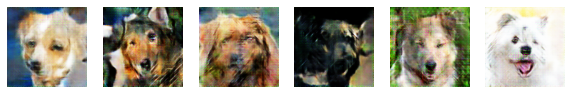

5.99969482421875 0.666015625 0.48587989807128906


Epoch [2/1000]:   0%|          | 0/200 [00:00<?, ?batch/s]

Epoch [2/1000], GLoss: -74383.772, Dloss: -132068.983, Time: 0:00:49.495218


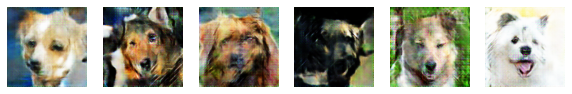

5.99969482421875 0.697265625 0.48502540588378906


Epoch [3/1000]:   0%|          | 0/200 [00:00<?, ?batch/s]

Epoch [3/1000], GLoss: -75264.987, Dloss: -131750.925, Time: 0:00:49.505410


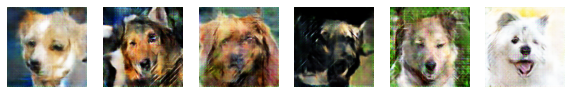

5.99969482421875 0.697265625 0.48490333557128906


Epoch [4/1000]:   0%|          | 0/200 [00:00<?, ?batch/s]

Epoch [4/1000], GLoss: -72753.885, Dloss: -135406.450, Time: 0:00:47.376933


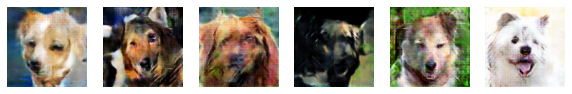

5.99969482421875 0.697265625 0.48624610900878906


Epoch [5/1000]:   0%|          | 0/200 [00:00<?, ?batch/s]

Epoch [5/1000], GLoss: -74599.872, Dloss: -133872.807, Time: 0:00:46.413684


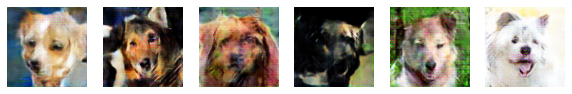

5.99969482421875 0.697265625 0.48587989807128906


Epoch [6/1000]:   0%|          | 0/200 [00:00<?, ?batch/s]

Epoch [6/1000], GLoss: -74185.904, Dloss: -135216.435, Time: 0:00:46.789086


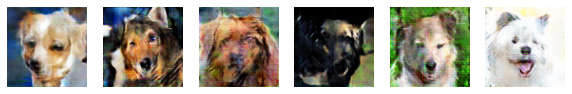

5.99969482421875 0.697265625 0.48539161682128906


Epoch [7/1000]:   0%|          | 0/200 [00:00<?, ?batch/s]

Epoch [7/1000], GLoss: -73460.777, Dloss: -136155.142, Time: 0:00:46.272313


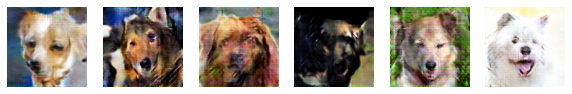

5.99969482421875 0.697265625 0.48539161682128906


Epoch [8/1000]:   0%|          | 0/200 [00:00<?, ?batch/s]

Epoch [8/1000], GLoss: -75206.623, Dloss: -133069.047, Time: 0:00:46.590075


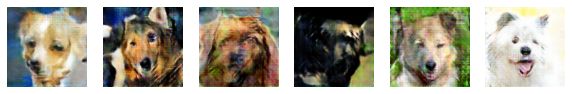

5.99969482421875 0.697265625 0.48453712463378906


Epoch [9/1000]:   0%|          | 0/200 [00:00<?, ?batch/s]

Epoch [9/1000], GLoss: -74204.901, Dloss: -134540.681, Time: 0:00:46.822965


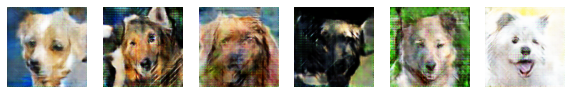

5.99969482421875 0.697265625 0.48478126525878906


Epoch [10/1000]:   0%|          | 0/200 [00:00<?, ?batch/s]

Epoch [10/1000], GLoss: -72713.779, Dloss: -133337.465, Time: 0:00:46.523441


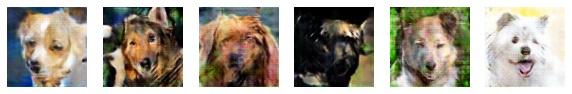

5.99969482421875 0.697265625 0.48636817932128906


Epoch [11/1000]:   0%|          | 0/200 [00:00<?, ?batch/s]

Epoch [11/1000], GLoss: -75378.471, Dloss: -136330.594, Time: 0:00:46.545826


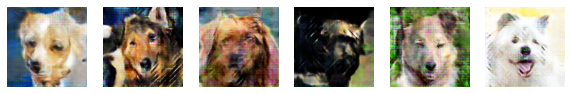

5.99969482421875 0.697265625 0.48539161682128906


Epoch [12/1000]:   0%|          | 0/200 [00:00<?, ?batch/s]

Epoch [12/1000], GLoss: -75524.827, Dloss: -135184.423, Time: 0:00:46.502775


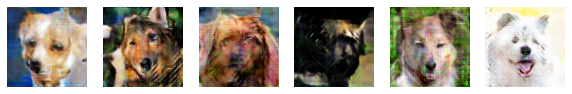

5.99969482421875 0.697265625 0.48734474182128906


Epoch [13/1000]:   0%|          | 0/200 [00:00<?, ?batch/s]

Epoch [13/1000], GLoss: -74125.370, Dloss: -135424.487, Time: 0:00:46.475912


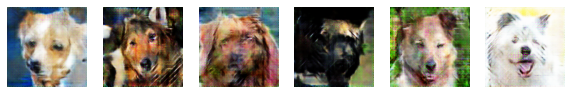

5.99969482421875 0.697265625 0.48502540588378906


Epoch [14/1000]:   0%|          | 0/200 [00:00<?, ?batch/s]

Epoch [14/1000], GLoss: -73417.462, Dloss: -134741.402, Time: 0:00:46.278614


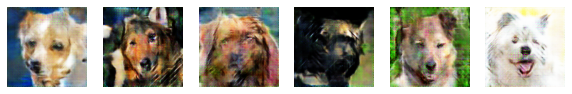

5.99969482421875 0.697265625 0.48539161682128906


Epoch [15/1000]:   0%|          | 0/200 [00:00<?, ?batch/s]

Epoch [15/1000], GLoss: -75410.244, Dloss: -136145.589, Time: 0:00:46.540567


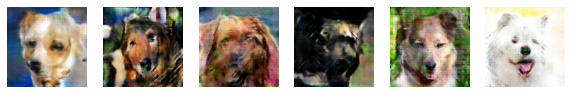

5.99969482421875 0.697265625 0.48490333557128906


Epoch [16/1000]:   0%|          | 0/200 [00:00<?, ?batch/s]

Epoch [16/1000], GLoss: -74837.074, Dloss: -134510.865, Time: 0:00:46.508313


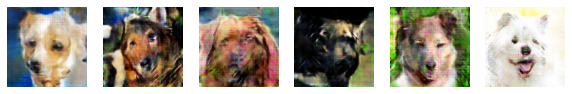

5.99969482421875 0.697265625 0.48539161682128906


Epoch [17/1000]:   0%|          | 0/200 [00:00<?, ?batch/s]

Epoch [17/1000], GLoss: -73629.863, Dloss: -136047.949, Time: 0:00:46.196664


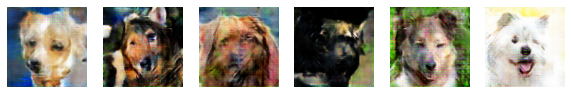

5.99969482421875 0.697265625 0.48490333557128906


Epoch [18/1000]:   0%|          | 0/200 [00:00<?, ?batch/s]

Epoch [18/1000], GLoss: -74905.022, Dloss: -136441.068, Time: 0:00:46.734515


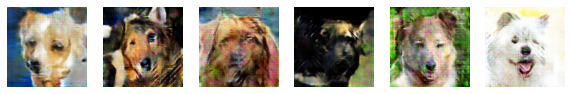

5.99969482421875 0.697265625 0.48587989807128906


Epoch [19/1000]:   0%|          | 0/200 [00:00<?, ?batch/s]

Epoch [19/1000], GLoss: -75504.336, Dloss: -134833.020, Time: 0:00:46.887598


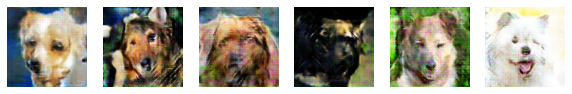

5.99969482421875 0.697265625 0.48587989807128906


Epoch [20/1000]:   0%|          | 0/200 [00:00<?, ?batch/s]

Epoch [20/1000], GLoss: -73260.732, Dloss: -135930.784, Time: 0:00:46.539883


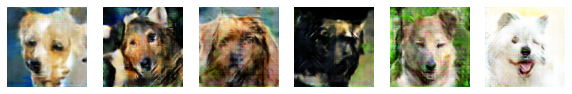

5.99969482421875 0.697265625 0.48685646057128906


Epoch [21/1000]:   0%|          | 0/200 [00:00<?, ?batch/s]

Epoch [21/1000], GLoss: -76220.653, Dloss: -137149.916, Time: 0:00:47.189592


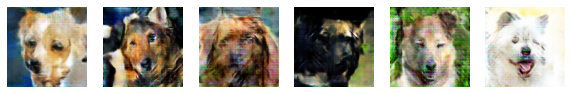

5.99969482421875 0.697265625 0.48551368713378906


Epoch [22/1000]:   0%|          | 0/200 [00:00<?, ?batch/s]

Epoch [22/1000], GLoss: -75382.070, Dloss: -136296.710, Time: 0:00:46.540345


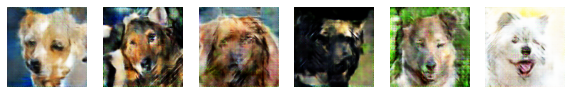

5.99969482421875 0.697265625 0.48539161682128906


Epoch [23/1000]:   0%|          | 0/200 [00:00<?, ?batch/s]

Epoch [23/1000], GLoss: -74321.933, Dloss: -135475.627, Time: 0:00:46.217018


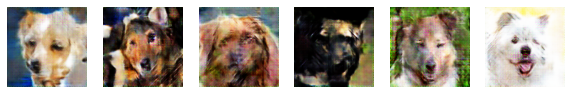

5.99969482421875 0.697265625 0.48624610900878906


Epoch [24/1000]:   0%|          | 0/200 [00:00<?, ?batch/s]

Epoch [24/1000], GLoss: -75014.899, Dloss: -141003.608, Time: 0:00:46.445389


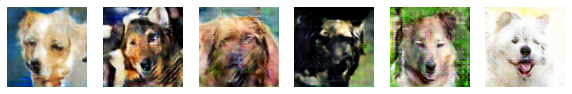

5.99969482421875 0.697265625 0.48587989807128906


Epoch [25/1000]:   0%|          | 0/200 [00:00<?, ?batch/s]

In [ ]:
num_epochs = 1000
patiance = 2

G = list()
D = list()
steps = 200
test = torch.load('tensor_test.pt').cuda()

for epoch in range(num_epochs):
    start=datetime.now()
    g_l = 0
    d_l = 0
    g_loss = 0
    rs = 0
    fs = 0
    n_b = len(dl.dataset) // batch_size + int(len(dl.dataset) % batch_size != 0)
    with tqdm(total=steps, position=0, desc=f'Epoch [{epoch + 1}/{num_epochs}]', unit='batch') as pbar:

        for i in range(steps):
            images = data.__next__()
            if (images.size()[0] != batch_size):
                continue
            #  получаем очередной batch     
            #for p in discriminator.parameters():
            #        p.data.clamp_(weight_cliping_limit, weight_cliping_limit)
            images = images.cuda()
            #real_labels  = real_labels.unsqueeze(1)
            # Получаем шум
            noise = Variable(torch.randn((len(images), 100, 1, 1)).cuda())
            #generator.eval()
            fake_images = generator(noise)
            #fake_labels = fake_labels.unsqueeze(1)
            # учим детектива
            d_loss, real_score, fake_score = train_discriminator_shuf(discriminator, images, fake_images)
            rs += real_score
            fs += fake_score
            d_l += d_loss
            D.append(d_loss)
            # получаем ответы обученного детектива
            if (i%5 == 4):
                for p in discriminator.layer5.parameters():
                    p.requires_grad = False  # to avoid computation
                noise = Variable(torch.randn((len(images), 100, 1, 1)).cuda())
                fake_images = generator(noise)
                #discriminator.eval()
                outputs = discriminator(fake_images)
                # учим фальшивомонетчика
                g_loss = train_generator(generator, outputs)
                g_l += g_loss
                G.append(g_loss)
                
                for p in discriminator.layer5.parameters():
                    p.requires_grad = True
            pbar.set_postfix(**{'Gloss': -g_loss, 'Dloss': -d_loss, '_Real': real_score, '_Fake': fake_score})
            pbar.update(1)
            sample = fake_images[0].cpu()
    print('Epoch [{}/{}], GLoss: {:.3f}, Dloss: {:.3f}, Time: {}'
        .format(epoch + 1, num_epochs, g_l/steps, d_l/steps, datetime.now()-start))
    plt.figure(figsize = (10,60))
    #generator.eval()
    tst = generator(test).cpu()
    for i in range(6):
        sample = tst[i]
        sample = (sample + 1.) / 2.
        sample = np.array(sample.detach().numpy() * 255, dtype=int)
        sample = np.swapaxes(sample,0,2)
        sample = np.swapaxes(sample,0,1)
        plt.subplot(1,6,i+1)
        plt.axis('off')  
        plt.imshow(sample)
    plt.show()
    t = torch.cuda.get_device_properties(0).total_memory
    r = torch.cuda.memory_reserved(0)
    a = torch.cuda.memory_allocated(0)
    print(t/(1024**3), r/(1024**3), a/(1024**3))

0.weight torch.Size([100, 2048, 4, 4])


<bound method Module.named_parameters of Sequential(
  (0): ConvTranspose2d(100, 2048, kernel_size=(4, 4), stride=(1, 1))
  (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
)>

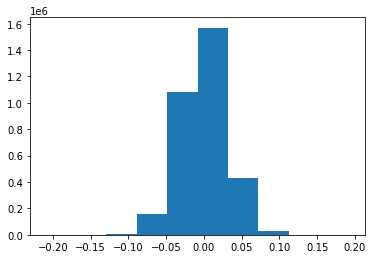

In [25]:
for p in generator.layer1.named_parameters():
    print(p[0], p[1].shape)
    plt.hist(p[1].cpu().detach().numpy().flatten())
    break
generator.layer1.named_parameters

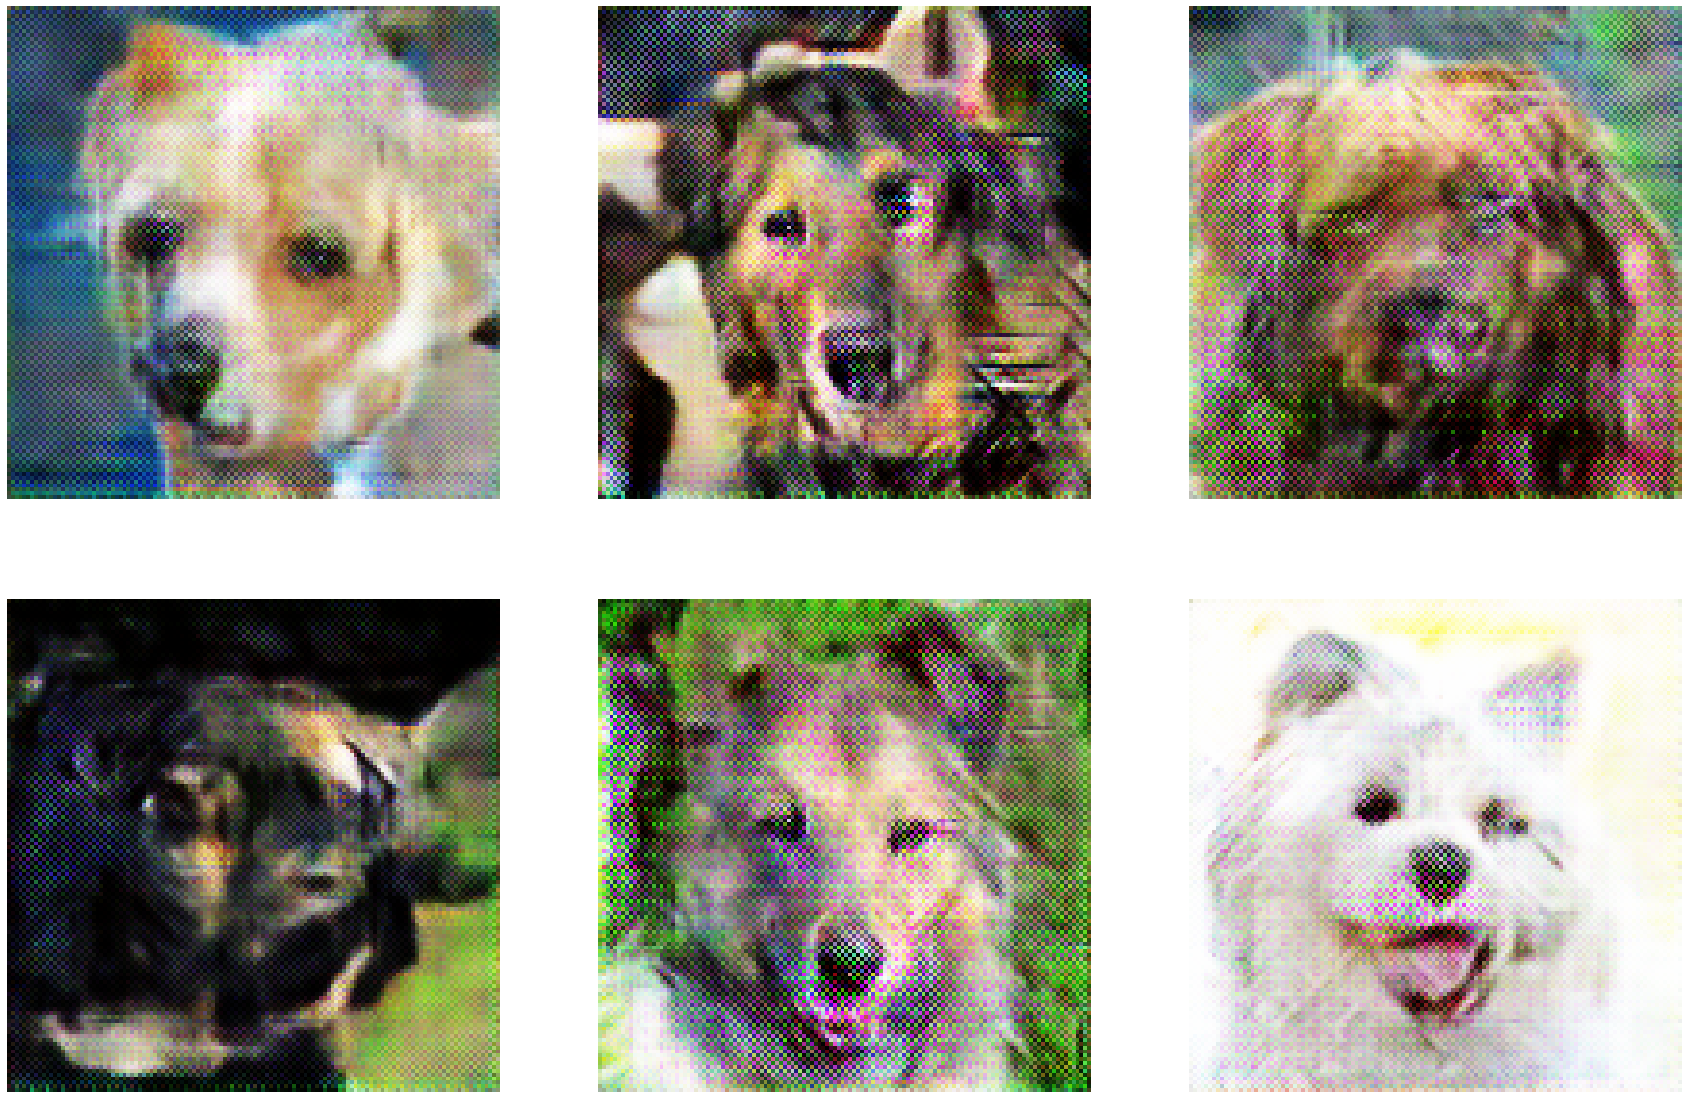

In [26]:
plt.figure(figsize = (30,20))
tst = generator(test).cpu()
for i in range(6):
    sample = tst[i]
    sample = (sample + 1.) / 2.
    sample = np.array(sample.detach().numpy() * 255, dtype=int)
    sample = np.swapaxes(sample,0,2)
    sample = np.swapaxes(sample,0,1)
    plt.subplot(2,3,i+1)
    plt.axis('off')  
    plt.imshow(sample)
plt.show()

In [27]:
torch.save(generator.state_dict(), 'catfaceD_gen_gp_128_4k')
torch.save(discriminator.state_dict(), 'catfaceD_disc_gp_128_4k')

In [48]:
G1 = np.load('catfaceF_gen_gp_128_4k.npy')
D1 = np.load('catfaceF_disc_gp_128_4k.npy')
G = np.load('catfaceF_gen_gp_128_2k.npy')
D = np.load('catfaceF_disc_gp_128_2k.npy')

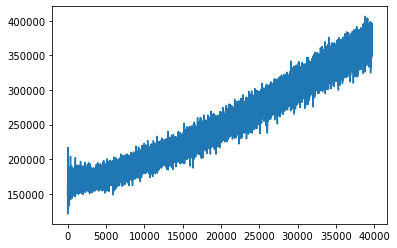

In [27]:
G = np.array(G)
D = np.array(D)
plt.plot([i for i in range(len(G))],-G)

In [28]:
np.save('catfaceD_gen_gp_128_2k.npy', G)
np.save('catfaceD_disc_gp_128_2k.npy', D)

In [50]:
G = np.concatenate((G,G1))
D = np.concatenate((D,D1))

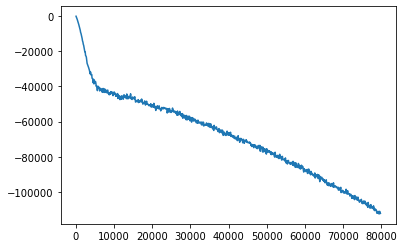

In [52]:
st = 100
G1 = list()
for i in range(int(G.shape[0] / st)):
    G1.append(np.mean(G[i*100:(i+1)*100]))
G1 = np.array(G1)
plt.plot([i*100 for i in range(len(G1))],G1)

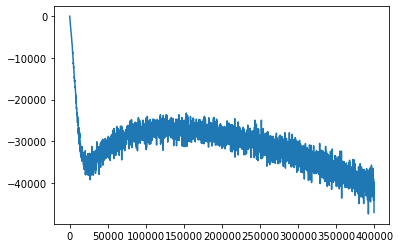

In [65]:
st = 100
D1 = list()
for i in range(int(D.shape[0] / st)):
    D1.append(np.mean(D[i*100:(i+1)*100]))
D1 = np.array(D1)
plt.plot([i*100 for i in range(len(D1))],D1)

In [53]:
import gc
torch.cuda.empty_cache()
gc.collect()

15145

In [60]:
#generator.eval()
generator.cpu()
discriminator.cpu()
test_noise = Variable(torch.randn((64, 100, 1, 1), requires_grad=False).cpu())
test_images = Variable(generator(test_noise), requires_grad=False)


In [61]:
score = discriminator(test_images).detach().numpy()
best = np.argmax(score)
best, score[best]

(24, array([[[-604451.]]], dtype=float32))

In [62]:
test_images = (test_images + 1.) / 2.
print(test_images.min(), test_images.max())

tensor(0.) tensor(1.)


In [63]:
test_images[23].shape

torch.Size([3, 128, 128])

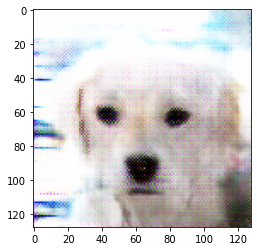

In [64]:
img = test_images[best].cpu().detach().numpy()
img = np.array(img * 255., dtype=int)
img = np.swapaxes(img,0,2)
img = np.swapaxes(img,0,1)

plt.imshow(img)

In [65]:
imgs = test_images.cpu().detach().numpy()
imgs = np.array(imgs * 255., dtype=int)
imgs = np.swapaxes(imgs,1,3)
imgs = np.swapaxes(imgs,1,2)

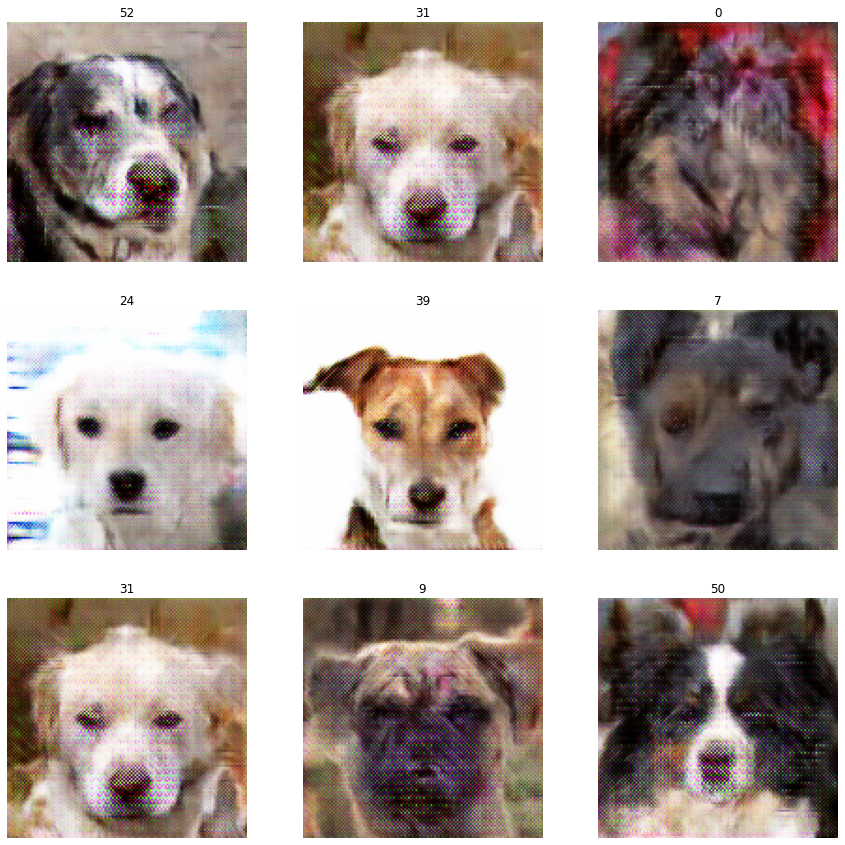

In [72]:
plt.figure(figsize=(15,15))
for i in range(9):
    ind = rand.randint(0,63)
    plt.subplot(3, 3, 1 + i)
    
    plt.title(str(ind))
    plt.axis('off')  
    plt.imshow(imgs[ind])
plt.show()

In [52]:
val = 999999999
img1 = np.zeros((60,60,3), dtype = float)
for d in ds:
    d = np.array(d * 255., dtype=int)
    d = np.swapaxes(d,0,2)
    d = np.swapaxes(d,0,1)
    #print(d.shape, img.shape)
    v = np.sum(np.square(d-img))
    if (v < val):
        val = v
        img1 = d
#img = img * 1. / len(ds)

KeyboardInterrupt: 

In [66]:
img1 = np.array(img1, dtype = int)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


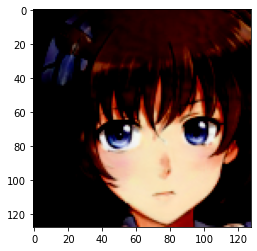

In [67]:
plt.imshow(img1)

In [122]:
ds[0].shape

torch.Size([3, 60, 60])

In [70]:
a = Variable(torch.randn((64, 3, IMG_SIZE, IMG_SIZE)))
b = Variable(torch.randn((64, 3, IMG_SIZE, IMG_SIZE)))
a.shape

torch.Size([64, 3, 60, 60])

In [74]:
c = torch.cat((a,b), 0)

In [75]:
c.shape

torch.Size([128, 3, 60, 60])

In [83]:
arr = np.random.randint(0,255,(64))
arr

array([213, 217, 245, 177, 167, 203, 119, 104, 221, 216, 187, 223,  45,
       228,  29,   5,  53, 185, 202,  46, 178, 135, 189, 122,  49, 105,
       174, 252, 105, 246, 169, 112,  90, 206, 179, 216, 142, 149,  71,
       245, 104, 202, 153,  50, 197,  37, 132, 152,  93, 187,  91,  53,
       138, 170, 182,  82, 196, 153,   4, 202, 197, 216,  54, 163])

In [84]:
a1 = np.arange((64))
np.random.shuffle(a1)
a1

array([12, 51, 59, 34, 21, 33, 15, 32, 54, 38, 17, 26,  2, 35, 16, 19,  7,
       49,  9, 29, 58, 27, 60, 63, 20, 24, 28, 31, 57, 37, 42, 62,  5, 45,
       47, 44,  3, 53, 30,  4, 10, 25, 48, 56, 43, 52, 36, 55, 41, 39,  8,
       61,  6,  0, 40, 11,  1, 22, 13, 50, 18, 23, 46, 14])

In [86]:
arr[a1]

array([ 45,  53, 202, 179, 135, 206,   5,  90, 182,  71, 185, 174, 245,
       216,  53,  46, 104, 187, 216, 246,   4, 252, 197, 163, 178,  49,
       105, 112, 153, 149, 153,  54, 203,  37, 152, 197, 177, 170, 169,
       167, 187, 105,  93, 196,  50, 138, 142,  82, 202, 245, 221, 216,
       119, 213, 104, 223, 217, 189, 228,  91, 202, 122, 132,  29])

In [28]:
a = torch.randint(low = 2, high = 3, size = (3,))

In [1]:
a = (1,2,3)

In [2]:
type(a)

tuple

In [6]:
b = {1,3,2}
type(b)

set

In [10]:
a = list()
a.append(b)
len(a)

1

In [11]:
a

[{1, 2, 3}]